In [1]:
import os
import numpy as np
import librosa
import librosa.display
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime
import sounddevice as sd


def trim_silence(audio, sr=16000, threshold=0.01, min_duration=0.1):
    """Supprime les silences avant et après le signal actif."""
    energy = np.abs(audio)
    active_indices = np.where(energy > threshold)[0]
    
    if len(active_indices) == 0:
        return np.array([])  # Retourner un tableau vide si aucun signal actif
    
    start_index = max(0, active_indices[0] - int(sr * min_duration))
    end_index = min(len(audio), active_indices[-1] + int(sr * min_duration))
    return audio[start_index:end_index]

def add_noise(data, noise_level=0.02):
    """Ajoute du bruit gaussien pour augmenter les données."""
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def augment_data(audio, sr=16000):
    """Augmente les données audio."""
    noisy_audio = add_noise(audio)
    shifted_audio = np.roll(audio, shift=int(0.1 * sr))  # Décalage temporel
    stretched_audio = librosa.effects.time_stretch(audio, rate=1.1)  # Étirement temporel
    return [audio, noisy_audio, shifted_audio, stretched_audio]

def detect_active_regions(audio, sr=16000, window_size=1600, hop_size=800, threshold=0.01):
    """Détecte les régions actives dans un signal audio en utilisant une fenêtre glissante."""
    active_regions = []
    for start in range(0, len(audio) - window_size + 1, hop_size):
        window = audio[start:start + window_size]
        energy = np.sum(np.abs(window))
        if energy > threshold:
            active_regions.append((start, start + window_size))
    if len(active_regions) == 0:
        return None
    return active_regions

def preprocess_audio_with_regions(audio, sr=16000):
    """Prépare un signal audio en utilisant les régions actives détectées."""
    regions = detect_active_regions(audio, sr=sr)
    if not regions:
        return None  # Silence détecté
    
    processed_features = []
    for start, end in regions:
        trimmed_audio = audio[start:end]
        trimmed_audio = librosa.util.normalize(trimmed_audio)
        features = extract_features(trimmed_audio, sr=sr)
        features_resized = cv2.resize(features, (64, 64)) / 255.0  # Réduction de la taille pour un modèle plus léger
        processed_features.append(features_resized.reshape(1, 64, 64, 1))
    if len(processed_features) == 0:
        return None
    return np.mean(processed_features, axis=0)  # Moyenne des régions actives

def extract_features(audio, sr=16000):
    """Extrait plusieurs caractéristiques d'un signal audio."""
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    mel = librosa.feature.melspectrogram(y=audio, sr=sr)
    features = np.vstack([mfccs, chroma, mel])
    return features

def save_spectrogram(spectrogram, folder, base_filename):
    """Sauvegarde un spectrogramme sous forme d'image PNG."""
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{base_filename}_{timestamp}.png"
    filepath = os.path.join(folder, filename)
    plt.figure(figsize=(4, 4))
    librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel', cmap='viridis')
    plt.axis('off')
    plt.savefig(filepath, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"Spectrogramme sauvegardé dans : {filepath}")

def load_and_augment_data(folder, label, sr=16000):
    """Charge les fichiers audio, applique des augmentations et génère des données augmentées."""
    dataset = []
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            file_path = os.path.join(folder, file)
            audio, _ = librosa.load(file_path, sr=sr)
            augmented_audios = augment_data(audio, sr)
            for aug_audio in augmented_audios:
                features = extract_features(aug_audio, sr=sr)
                features_resized = cv2.resize(features, (64, 64))  # Réduction de la taille pour un modèle plus léger
                dataset.append((features_resized, label))
    return dataset

def build_model(input_shape, num_classes):
    """Construit un modèle CNN léger pour la reconnaissance vocale."""
    model = models.Sequential([
        layers.Input(shape=input_shape),
        # Downsample the input.
        layers.Resizing(32, 32),
        layers.Normalization(),
        layers.Conv2D(16, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),  # Increased dropout
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax'),
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def record_audio(sr=16000, duration=1.5):
    """Enregistre un court extrait audio via le microphone."""
    print("Parlez maintenant...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
    sd.wait()
    print("Enregistrement terminé.")
    return audio.flatten()

def preprocess_audio(audio, sr=16000):
    """Prépare un signal audio pour la prédiction."""
    trimmed_audio = trim_silence(audio, sr=sr)
    if len(trimmed_audio) == 0:
        return None  # Retourner None si aucun signal actif
    
    trimmed_audio = librosa.util.normalize(trimmed_audio)
    features = extract_features(trimmed_audio, sr=sr)
    features_resized = cv2.resize(features, (64, 64)) / 255.0  # Réduction de la taille pour un modèle plus léger
    return features_resized.reshape(1, 64, 64, 1)

def predict_audio(model, label_encoder, audio, sr=16000):
    """Prédit un mot à partir d'un signal audio donné."""
    if audio is None:
        return "Silence détecté", 0.0
    spectrogram_resized = preprocess_audio(audio, sr=sr)
    if spectrogram_resized is None:
        return "Silence détecté", 0.0
    
    prediction = model.predict(spectrogram_resized)
    predicted_index = np.argmax(prediction)
    confidence = prediction[0, predicted_index]
    return label_encoder.inverse_transform([predicted_index])[0], confidence

def evaluate_model(model, X_test, y_test, label_encoder):
    """Évalue les performances du modèle avec des données de test."""
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues')
    plt.show()

def plot_training_curves(history):
    """Trace les courbes d'entraînement et de validation."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, acc, label='Précision entraînement')
    plt.plot(epochs, val_acc, label='Précision validation')
    plt.title('Précision')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, label='Perte entraînement')
    plt.plot(epochs, val_loss, label='Perte validation')
    plt.title('Perte')
    plt.legend()
    plt.show()

def plot_roc(y_test, y_pred, num_classes):
    """Trace les courbes ROC pour chaque classe."""
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test == i, y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Classe {i} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title("Courbe ROC")
    plt.legend()
    plt.show()


In [2]:
# Charger les données
allumer_folder = r"C:/Users/flavi/projet/allumer_mp3"
eteindre_folder = r"C:/Users/flavi/projet/eteindre_mp3"
inconnu_folder = r"C:/Users/flavi/projet/inconnu"


data_folders = {"allumer": allumer_folder, "eteindre": eteindre_folder, "inconnu": inconnu_folder}
dataset = []
for label, folder in data_folders.items():
    dataset += load_and_augment_data(folder, label)


C:\Users\flavi\AppData\Roaming\Python\Python38\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [3]:
X, y = zip(*dataset)
X = np.array(X).reshape(-1, 64, 64, 1) / 255.0  # Normalisation et réduction de la taille
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Calcul des poids des classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [5]:
# Construction, entraînement et évaluation du modèle
model = build_model(input_shape=(64, 64, 1), num_classes=len(data_folders))

history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2, batch_size=32, class_weight=class_weights_dict)


Epoch 1/1000
69/69 [==============================] - 12s 46ms/step - loss: 2.3774 - accuracy: 0.3724 - val_loss: 2.2302 - val_accuracy: 0.4560
Epoch 2/1000
69/69 [==============================] - 2s 29ms/step - loss: 2.1028 - accuracy: 0.4228 - val_loss: 1.9863 - val_accuracy: 0.5147
Epoch 3/1000
69/69 [==============================] - 2s 25ms/step - loss: 1.8874 - accuracy: 0.4663 - val_loss: 1.7978 - val_accuracy: 0.5220
Epoch 4/1000
69/69 [==============================] - 2s 26ms/step - loss: 1.7167 - accuracy: 0.4416 - val_loss: 1.6471 - val_accuracy: 0.5275
Epoch 5/1000
69/69 [==============================] - 2s 26ms/step - loss: 1.5823 - accuracy: 0.4920 - val_loss: 1.5277 - val_accuracy: 0.5366
Epoch 6/1000
69/69 [==============================] - 2s 26ms/step - loss: 1.4749 - accuracy: 0.4989 - val_loss: 1.4329 - val_accuracy: 0.5586
Epoch 7/1000
69/69 [==============================] - 1s 14ms/step - loss: 1.3870 - accuracy: 0.5121 - val_loss: 1.3544 - val_accuracy: 0.556

22/22 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

     allumer       0.96      0.91      0.93       314
    eteindre       0.89      0.95      0.92       234
     inconnu       0.85      0.86      0.86       135

    accuracy                           0.91       683
   macro avg       0.90      0.91      0.90       683
weighted avg       0.92      0.91      0.91       683



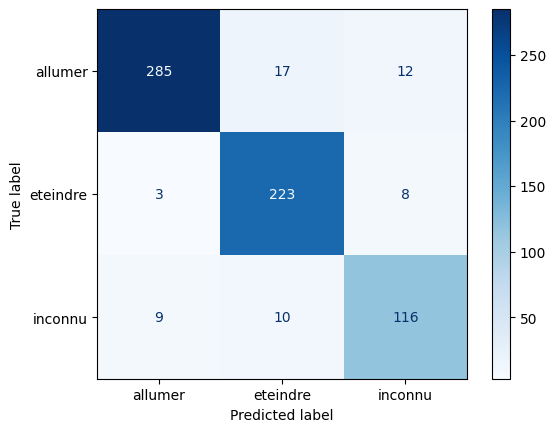

In [6]:
evaluate_model(model, X_test, y_test, LabelEncoder().fit(list(data_folders.keys())))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0

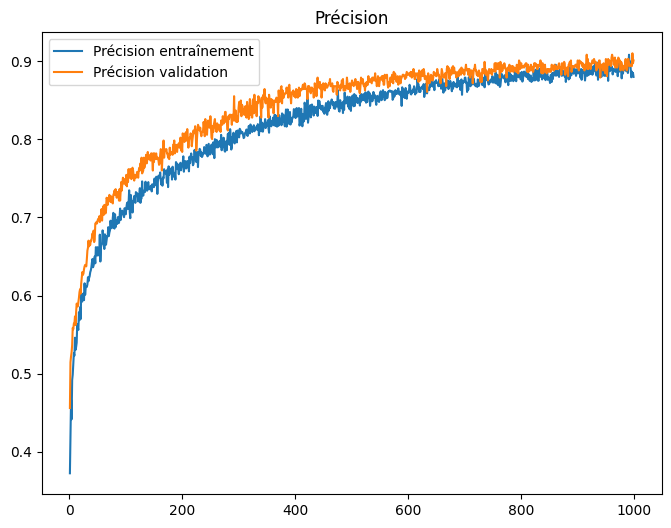

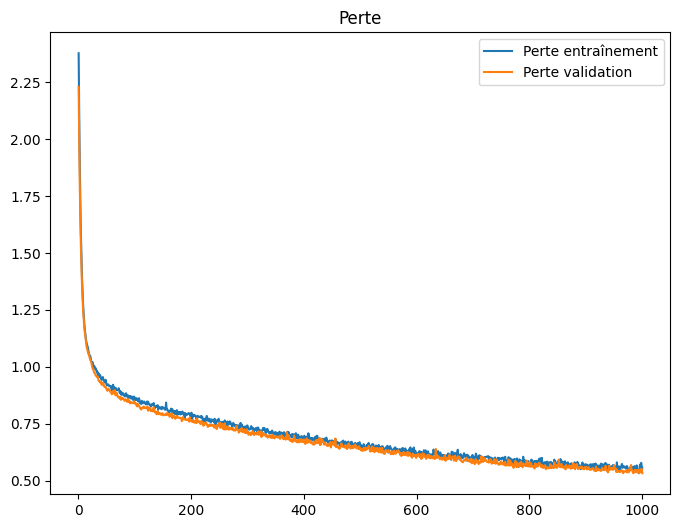

In [8]:
# Tracer les courbes d'entraînement
plot_training_curves(history)

22/22 [==============================] - 0s 4ms/step


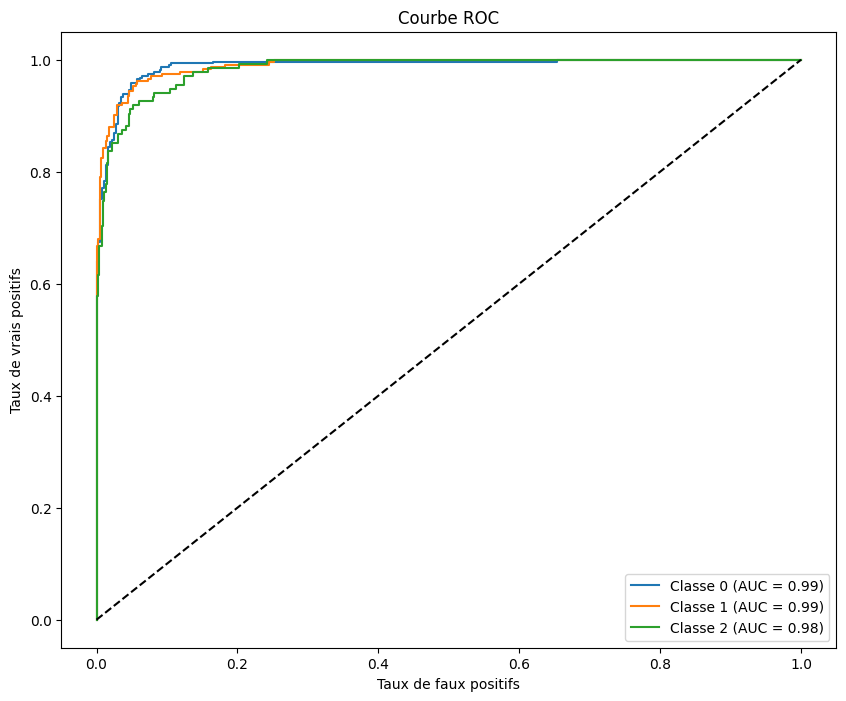

In [9]:
# Tracer la courbe ROC
predictions = model.predict(X_test)
plot_roc(y_test, predictions, num_classes=len(data_folders))

In [11]:
# Tester la prédiction en temps réel
audio = record_audio()
predicted_label, confidence = predict_audio(model, LabelEncoder().fit(list(data_folders.keys())), audio)
print(f"Prédiction en temps réel : {predicted_label} (Confiance : {confidence:.2f})").


SyntaxError: invalid syntax (2365031369.py, line 4)

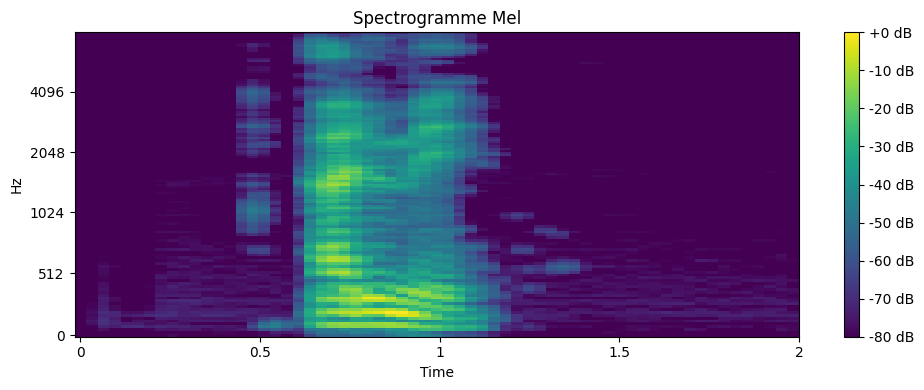

In [12]:
# Charger un seul fichier audio
file_path = r"C:/Users/flavi/projet/allumer_wav/allumer_20241226_133934.wav"  # Remplacez par un chemin réel
audio, sr = librosa.load(file_path, sr=16000)

# Générer un spectrogramme Mel
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Afficher le spectrogramme
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, x_axis='time', y_axis='mel', sr=sr, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogramme Mel")
plt.tight_layout()
plt.show()
